<a href="https://colab.research.google.com/github/peterrrock2/gerrychain_migration/blob/main/Graph_updates_tester_sln.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
%%bash

version="old"
version="new"

if [ ! -f pyproject.toml ]
then
  if [[ $version == "old" ]]
  then
    wget -q https://raw.githubusercontent.com/peterrrock2/gerrychain_migration/refs/heads/main/old_gc/pyproject.toml
    wget -q https://raw.githubusercontent.com/peterrrock2/gerrychain_migration/refs/heads/main/old_gc/uv.lock
  else
    wget -q https://raw.githubusercontent.com/peterrrock2/gerrychain_migration/refs/heads/main/new_gc/pyproject.toml
    wget -q https://raw.githubusercontent.com/peterrrock2/gerrychain_migration/refs/heads/main/new_gc/uv.lock

    echo "Please restart the runtime"
  fi

  # Point uv's "project environment" at the running Python's prefix
  export UV_PROJECT_ENVIRONMENT="$(python -c 'import sysconfig; print(sysconfig.get_config_var("prefix"))')"

  # Install exactly what's in uv.lock WITHOUT rewriting it
  # --inexact avoids removing Colab's preinstalled packages
  # --no-install-project installs deps but not local project as a package
  uv sync -q --frozen --inexact --no-dev --no-install-project
fi

In [ ]:
import geopandas as gpd
from gerrychain import Graph
import networkx as nx
import random
from shapely import Polygon
import warnings

warnings.filterwarnings("always")

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

In [ ]:
def make_square(start_x: float, start_y: float, width: float = 1):
    x0, y0 = start_x, start_y
    x1, y1 = x0 + width, y0 + width
    return Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)])


def make_grid(width: int, height: int):
    all_polys = []
    for i in range(width):
        for j in range(height):
            all_polys.append(make_square(i, j))
    return all_polys


def random_pop(max_pop: int = 10):
    if max_pop < 1:
        raise ValueError("Max population must be at least 1")
    if int(max_pop) != max_pop:
        raise ValueError("Max population must be an integer")
    return random.randint(1, max_pop)


def display_gdf(input_gdf):
    _, ax = plt.subplots()
    ax.set_axis_off()
    input_gdf.plot(ax=ax, edgecolor="black")
    for label, row in input_gdf.iterrows():
        pos = row.geometry.representative_point()
        x, y = pos.x, pos.y
        ax.text(
            x=x,
            y=y,
            s=label,
            ha="center",
            va="center",
            color="white",
            fontsize=12,
            fontweight=700,
        )

    plt.show()


def display_gdf_and_dual_graph(input_gdf, input_graph):
    _, ax = plt.subplots()
    ax.set_axis_off()

    input_gdf.plot(ax=ax, edgecolor="black", color="lightblue")

    pts = input_gdf.geometry.representative_point()
    pos = {idx: (p.x, p.y) for idx, p in pts.items()}

    xs, ys = zip(*pos.values())
    ax.plot(
        xs,
        ys,
        marker="o",
        markersize=10,
        markerfacecolor="#656565",
        markeredgecolor="#656565",
        linestyle="",
    )

    segments = [(pos[u], pos[v]) for u, v in input_graph.edges if u in pos and v in pos]
    ax.add_collection(LineCollection(segments, colors="#656565", linewidths=3))

    plt.show()

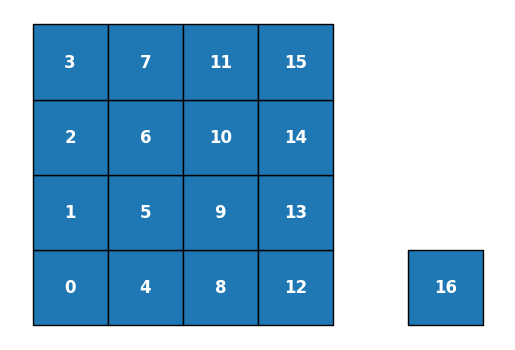

In [4]:
gdf = gpd.GeoDataFrame(
    {"geometry": make_grid(4, 4) + [make_square(5, 0)]}, crs="EPSG:4396"
)

display_gdf(gdf)

# Tasks

1. Make a graph object
2. Add population data to the graph under the key "TOTPOP"
    - Use the provided `random_pop` method.
3. Compute the total population using the graph object itself

In [5]:
random.seed(42)

graph = Graph.from_geodataframe(gdf)

for node in graph:
    # graph.nodes[node]["TOTPOP"] = random_pop()
    graph.node_data(node)["TOTPOP"] = random_pop()

tot_pop = 0
# for node, data in graph.nodes(data=True):
#     tot_pop += data["TOTPOP"]

for node in graph:
    tot_pop += graph.node_data(node)["TOTPOP"]

print(f"The total population is {tot_pop}")

The total population is 70


/mnt/efs/h/Dropbox/MADLAB/Migration_GerryChain/.venv/lib/python3.12/site-packages/gerrychain/graph/graph.py:1281: UserWarning: Found islands (degree-0 nodes). Indices of islands: {16}
  warnings.warn("Found islands (degree-0 nodes). Indices of islands: {}".format(islands))


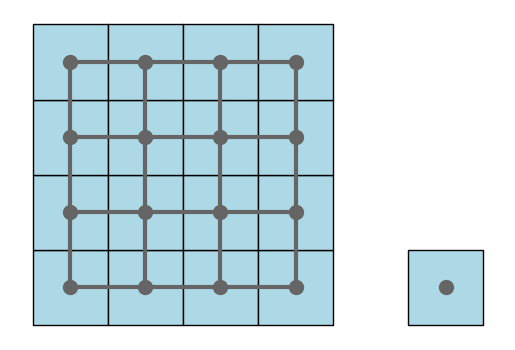

In [6]:
display_gdf_and_dual_graph(gdf, graph)

4. Now check to see if the graph is connected programmatically 

In [ ]:
nx.is_connected(graph)

False

5. Connect the graph by adding an edge between node 12 and 16 and between node 13 and 16.
6. Display the graph to make sure that it is connected

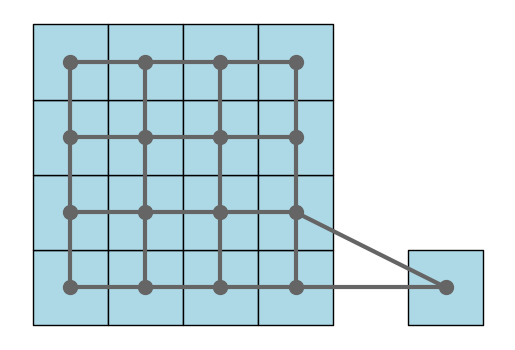

In [8]:
graph.add_edges_from([(12, 16), (13, 16)])


# Display the graph to check.
display_gdf_and_dual_graph(gdf, graph)

7. Add a random weight to each edge in the graph using the attribute "weight"
    - Use of `random.random()` is recommended here.
8. Make a minimum spanning tree.
9. Display the minimum spanning tree


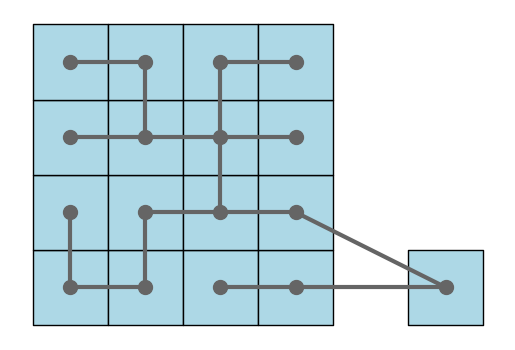

In [9]:
# for _, _, data in graph.edges(data=True):
#     data["weight"] = random.random()

for edge in graph.edges:
    graph.edge_data(edge)["weight"] = random.random()

# tree = nx.minimum_spanning_tree(graph)

tree = graph.minimum_spanning_tree_from_edge_weight("weight")

display_gdf_and_dual_graph(gdf, tree)